# E-MOSAIC

引用自[E. R. Q. Fernandes, A. C. P. L. F. de Carvalho and X. Yao, "Ensemble of Classifiers Based on Multiobjective Genetic Sampling for Imbalanced Data," in IEEE Transactions on Knowledge and Data Engineering, vol. 32, no. 6, pp. 1104-1115, 1 June 2020, doi: 10.1109/TKDE.2019.2898861.]


## 数据集的预处理 

In [1]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from utils.dataset_utils import get_classes_indexes_counts
import scipy.io as sio  # 从.mat文件中读取数据集
from ucimlrepo import fetch_ucirepo

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 随机种子
random_seed = 42
print("#########################加载数据集#########################")
# 数据集
mat_data = sio.loadmat('../../data/dataset/Contraceptive.mat')

dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
# 显示数据集分布
print("特征数据:", dataset_x.shape)
print("label:", dataset_y.shape)
# 统计每个类别的个数
classes, counts = get_classes_indexes_counts(dataset_y)  #np.argmax(y_onehot, axis=1)找最大值的索引，将0-1序列转化为0,1,2,3......的整数标签
print("每种类别的分布：", counts)
print("#########################划分数据集#########################")
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.3, random_state=random_seed)
# 显示数据集分布
print("特征数据:", x_train.shape)
print("label:", y_train.shape)
# 统计每个类别的个数 
classes_train, counts_train = get_classes_indexes_counts(y_train)
# 计算每个类的权重
weights_train = (1 / counts_train.astype(float)) / np.sum(1 / counts_train.astype(float))
print("训练集每种类别的分布：", counts_train)
print("训练集每种类别的权重：", weights_train)
classes_test, counts_test = get_classes_indexes_counts(y_test)
print("测试集每种类别的分布：", counts_test)
print("#########################平衡数据集#########################")
# 确定每个类别的分布
num_instances = int(counts_train.min() * 1.0)  # 向下取整
print("最小数量:", num_instances)
# 在每个类别中随机的选择该数量的实例的索引
balanced_classes = np.array([])
for indexes in classes_train:
    random_selecte_indices = np.random.choice(indexes, size=num_instances, replace=False)
    balanced_classes = np.hstack((balanced_classes, random_selecte_indices))
balanced_classes = np.sort(balanced_classes).astype(int)
# 得到平衡的数据集
balanced_dataset_x = []
balanced_dataset_y = []
for index in balanced_classes:
    balanced_dataset_x.append(x_train[index])
    balanced_dataset_y.append(y_train[index])
balanced_dataset_x = np.array(balanced_dataset_x)
balanced_dataset_y = np.array(balanced_dataset_y).astype(int)
# 显示数据集分布
print("平衡的数据集的特征数据:", balanced_dataset_x.shape)
print("label:", balanced_dataset_y.shape)
# 统计每个类别的分布
classes_balanced_dataset, counts_balanced_dataset = get_classes_indexes_counts(balanced_dataset_y)
print("平衡的数据集中每种类别的分布：", counts_balanced_dataset)

#########################加载数据集#########################
特征数据: (1473, 9)
label: (1473,)
每种类别的分布： [629 333 511]
#########################划分数据集#########################
特征数据: (1031, 9)
label: (1031,)
训练集每种类别的分布： [435 232 364]
训练集每种类别的权重： [0.24569693 0.46068174 0.29362133]
测试集每种类别的分布： [194 101 147]
#########################平衡数据集#########################
最小数量: 232
平衡的数据集的特征数据: (696, 9)
label: (696,)
平衡的数据集中每种类别的分布： [232 232 232]


## 评价函数
（Acc1、Acc2、Acc3）
Acc1、Acc2是实例选择选了多少，S就是多少；而Acc3是划分完数据集之后，每个类的数量作为si

In [2]:
from scipy.stats import gmean
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score
from scipy.stats import mode


##########################适应度函数（Acc1,Acc2,Acc3）#################################
def fitness_function(individual):
    # 使用训练数据进行预测
    y_sub, ind_pred = individual.y_sub_and_pred[0], individual.y_sub_and_pred[1]  # 获取个体的实例选择标签和预测标签
    ######################计算混淆矩阵#########################
    cm = confusion_matrix(y_sub, ind_pred)
    tp_per_class = cm.diagonal()  # 对角线元素表示每个类预测正确的个数，对角线求和，即所有预测正确的实例个数之和，计算Acc1
    s_per_class = cm.sum(axis=1)
    Acc1 = np.sum(tp_per_class) / np.sum(s_per_class)  # Acc1
    Acc2 = np.mean(tp_per_class.astype(float) / s_per_class.astype(float))  # Acc2
    Acc3 = np.mean((tp_per_class.astype(float) / s_per_class.astype(float)) * weights_train)  # Acc3
    return round(Acc1, 6), round(Acc2, 6), round(Acc3, 6)


# 集成分类器的投票
def vote_ensembles(ensembles):
    y_pred_labels_ensembles = []
    y_pred_prob_labels_ensembles = []
    for ensemble in ensembles:
        ind_pred = ensemble.predict(x_test)  # 计算accuracy、PPV
        ind_proba = ensemble.predict_proba(x_test)
        y_pred_labels_ensembles.append(ind_pred)
        y_pred_prob_labels_ensembles.append(ind_proba)
    # 按列投票，取每列中出现次数最多的类别作为最终分类结果
    final_pred_result = mode(y_pred_labels_ensembles, axis=0, keepdims=False).mode.flatten()
    # 堆叠为三维数组
    stacked_predictions_prob = np.stack(y_pred_prob_labels_ensembles, axis=0)
    # 对第一个维度 (num_classifiers) 求平均
    ensemble_predictions_prob = np.mean(stacked_predictions_prob, axis=0)
    # 计算 ROC AUC（ovo+macro）
    auc_ovo_macro = roc_auc_score(y_test, ensemble_predictions_prob, multi_class="ovo", average="macro")
    cm = confusion_matrix(y_test, final_pred_result)
    # 计算每类召回率（每类正确预测个数 / 该类总数）
    recall_per_class = cm.diagonal() / cm.sum(axis=1)

    # 计算G-Mean
    geometric_mean = gmean(recall_per_class)
    # 计算准确率
    accuracy = accuracy_score(y_test, final_pred_result)
    print(f'Accuracy: {accuracy:.2f}')
    # 打印分类报告
    print("Classification Report:")
    print(classification_report(y_test, final_pred_result))
    # 打印混淆矩阵
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, final_pred_result))
    return geometric_mean, auc_ovo_macro, np.array(["{:.6f}".format(x) for x in recall_per_class]).tolist()  # 保留六位小数
# 运行NSGA-II算法并绘图
def plot_pareto(pareto_fronts, ax):
    colors = plt.cm.viridis(np.linspace(0, 1, len(pareto_fronts)))
    for i, front in enumerate(pareto_fronts):
        front_points = np.array([ind.fitness.values for ind in front])
        ax.scatter(front_points[:, 0], front_points[:, 1], front_points[:, 2], label=f"Front {i}", color=colors[i])

## NDGA-II

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from instance_selection.multi_objective.genetic_operator import selNSGA2, mutate_binary_inversion, selTournamentDCD, \
    exponential_distribution, find_duplicates, remove_duplicates
import warnings

warnings.filterwarnings("ignore")  # 忽略警告
from sklearn.neural_network import MLPClassifier

import array
import random
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools
from mpl_toolkits.mplot3d import Axes3D

# 最大化评价目标
creator.create("FitnessMaxAndMax", base.Fitness, weights=(1.0, 1.0, 1.0))
'''
fitness:适应度：Gmean和mAUC
pfc：每个分类器的成对故障信用，用于评估分类器集合的多样性
'''
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMaxAndMax, pfc=None, mlp=None,
               y_sub_and_pred=None)
toolbox = base.Toolbox()

NDIM = num_instances
# 设置参数
lambda_ = 1.2  # 指数分布的参数λ（lambda）在下面的函数中，该值越大越偏向于1
threshold = 1.0  # 阈值（阈值决定了生成0或1）

# 二进制编码
toolbox.register("attr_binary", exponential_distribution, lambda_, threshold)  # 0-1编码
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_binary, n=num_instances)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 适应度函数
toolbox.register("evaluate", fitness_function)

# 单点交叉
toolbox.register("mate", tools.cxOnePoint)

# 二进制突变
toolbox.register("mutate", mutate_binary_inversion)

# NSGA-II选择（非支配排序后）
toolbox.register("select", selNSGA2, x_test=x_test, y_test=y_test)
# toolbox.register("select", tools.selNSGA2)

# 找到种群中重复个体的索引对
toolbox.register("find_duplicates", find_duplicates)

# 去重
toolbox.register("remove_duplicates", remove_duplicates)

## 种群的迭代

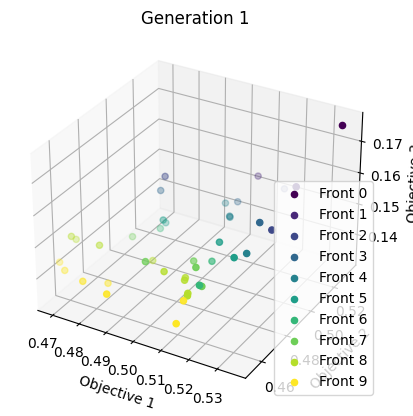

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


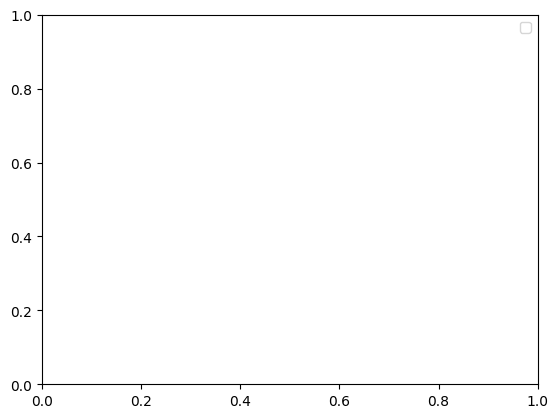

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


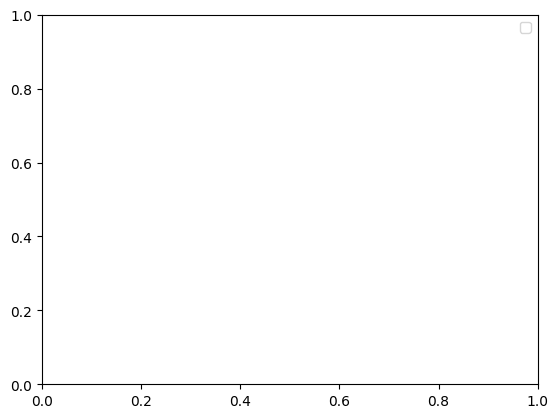

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


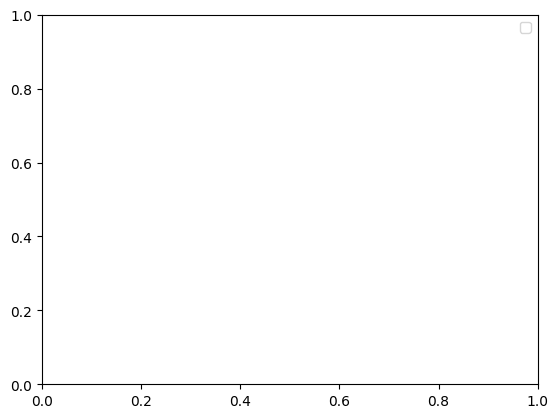

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


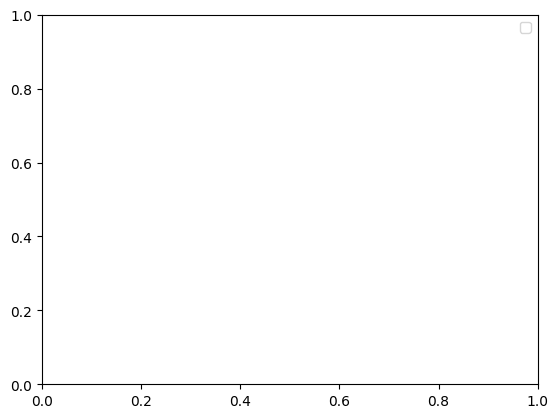

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


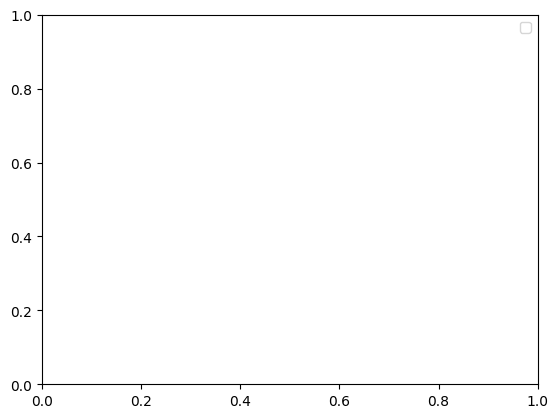

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


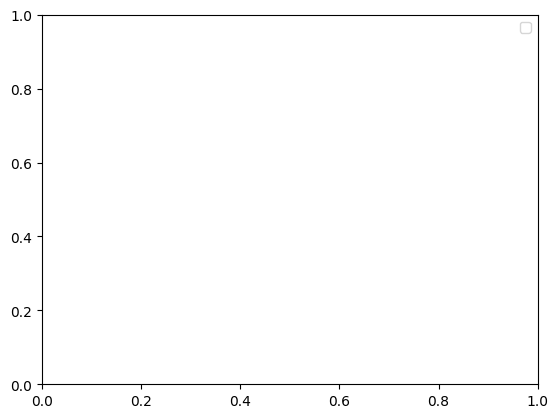

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


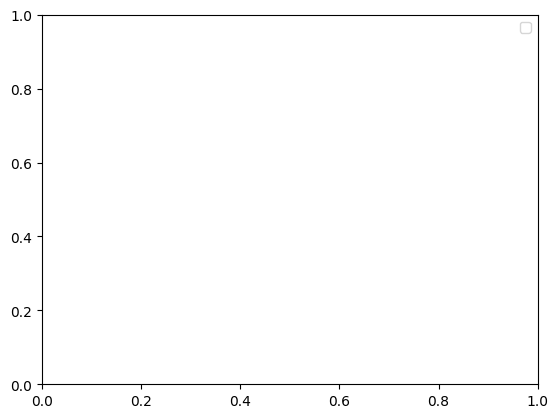

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


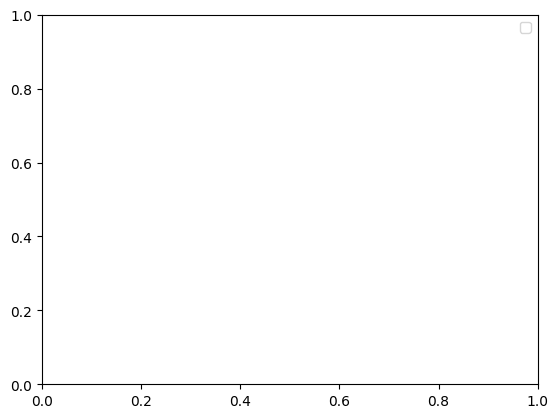

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


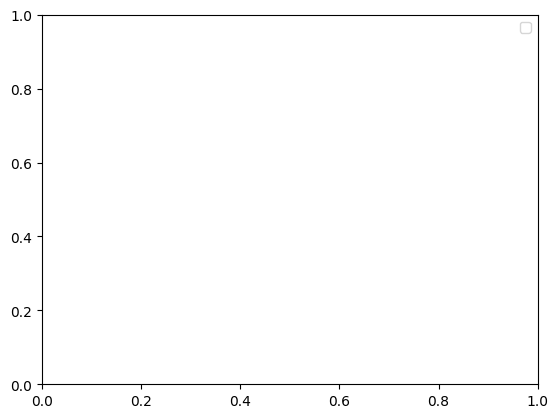

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


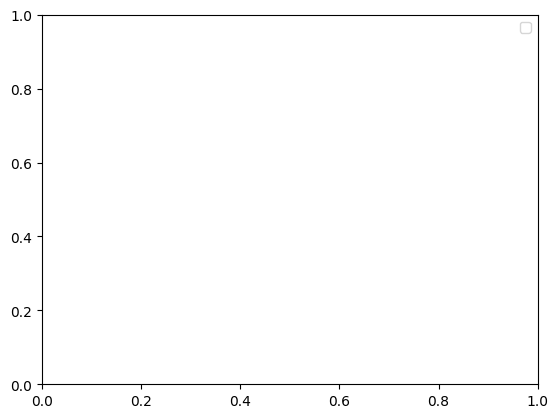

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


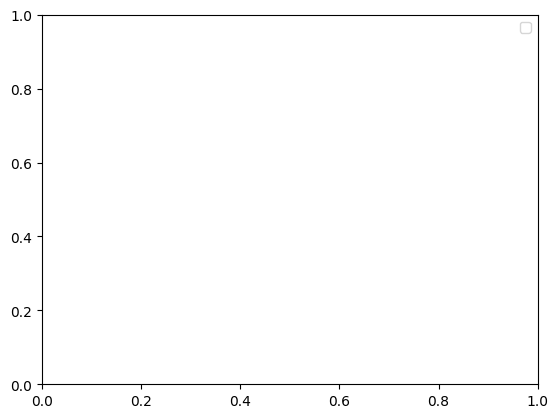

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


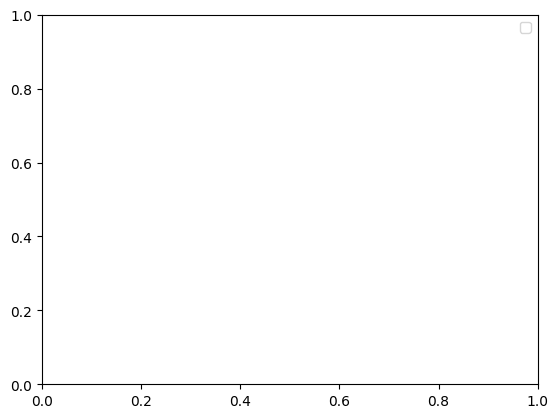

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


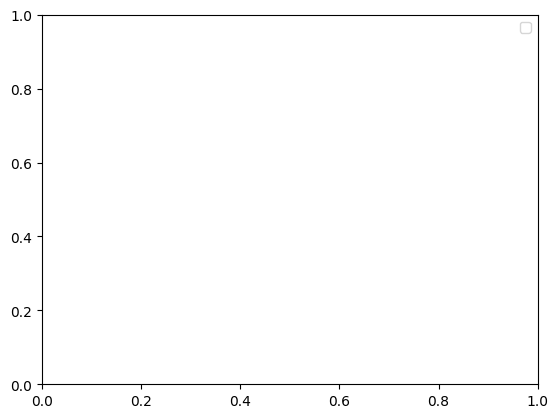

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


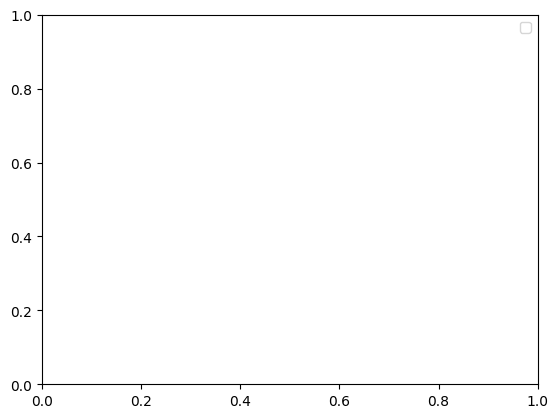

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


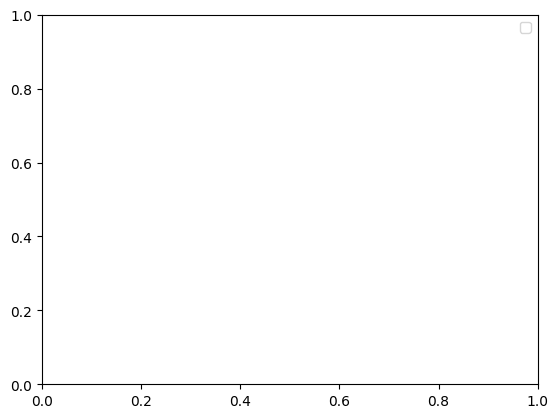

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


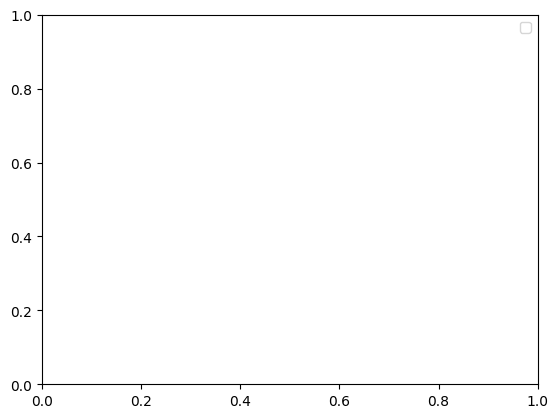

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


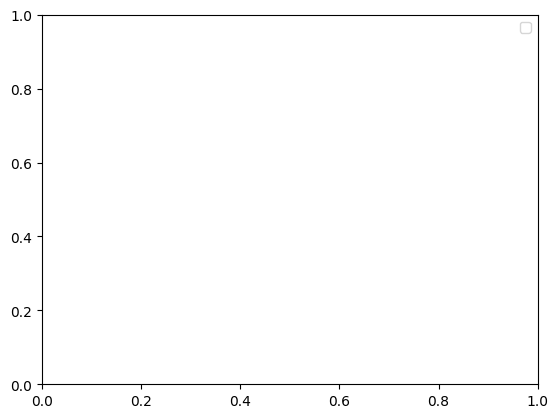

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


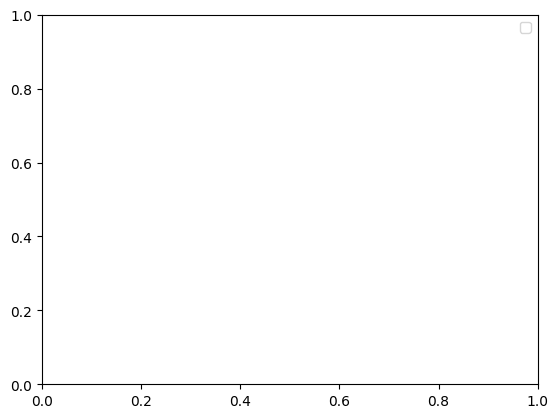

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


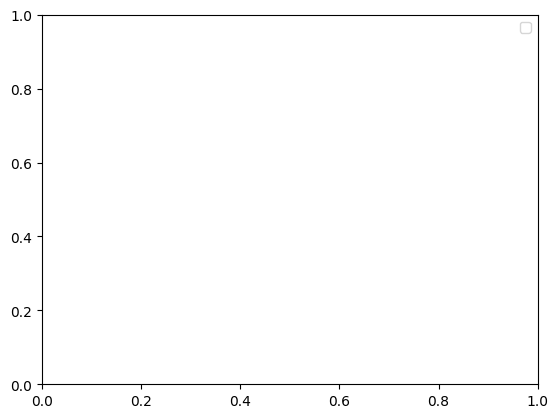

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


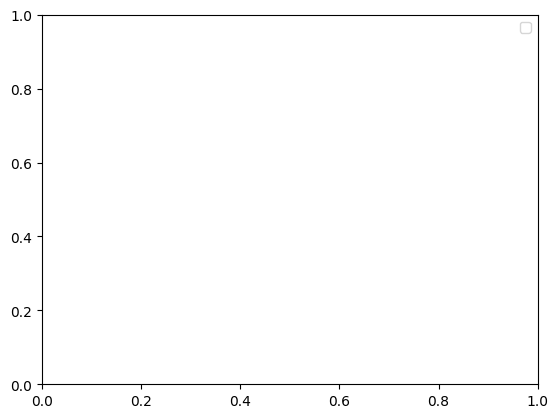

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


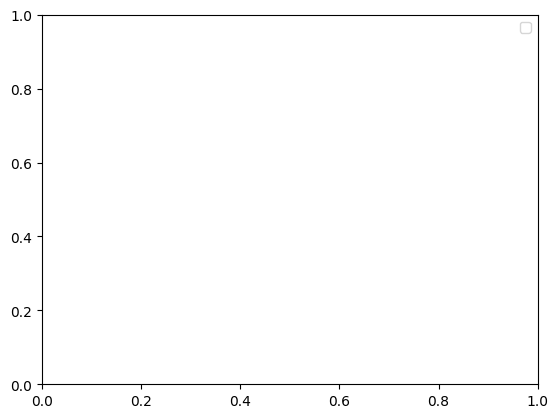

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


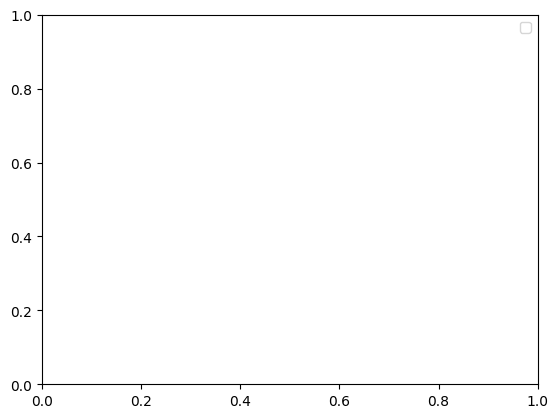

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


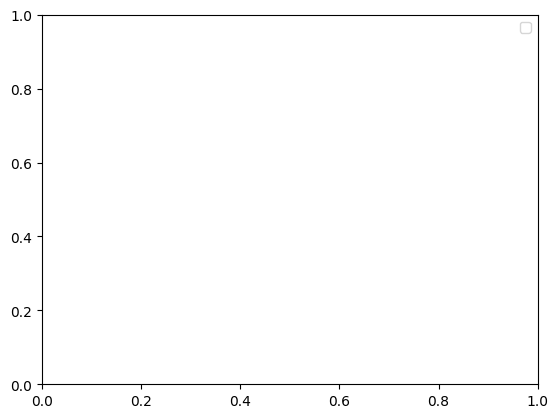

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


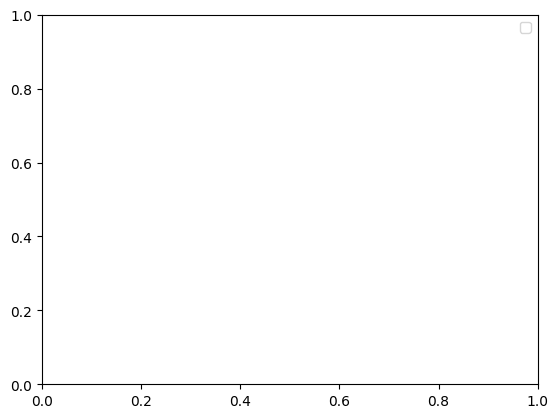

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


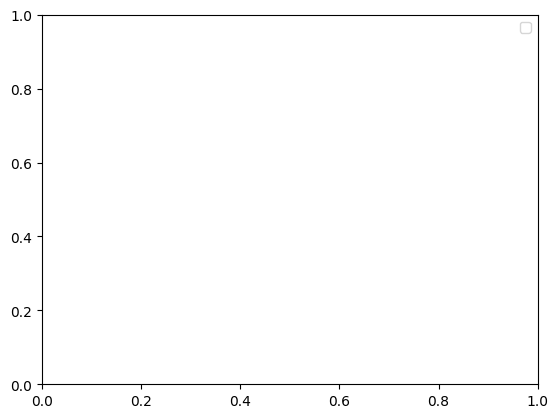

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


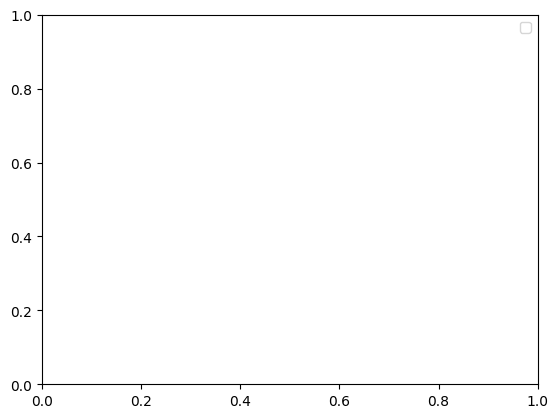

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


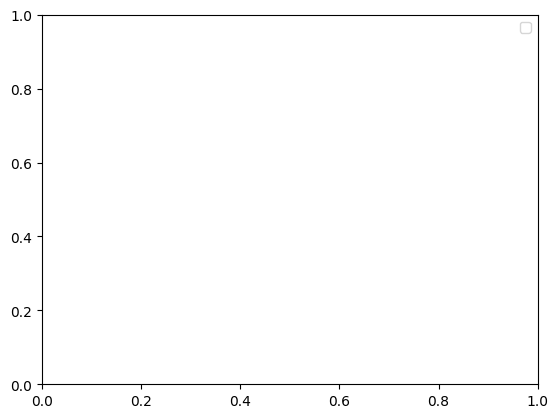

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


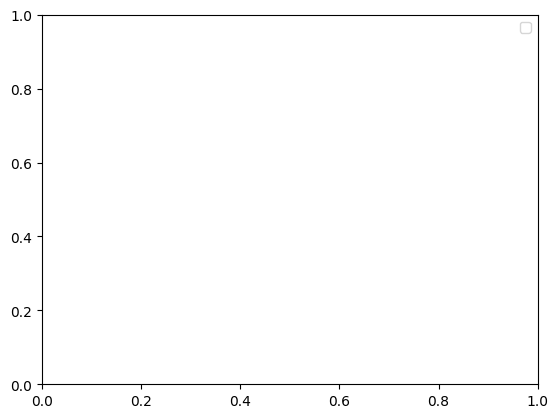

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


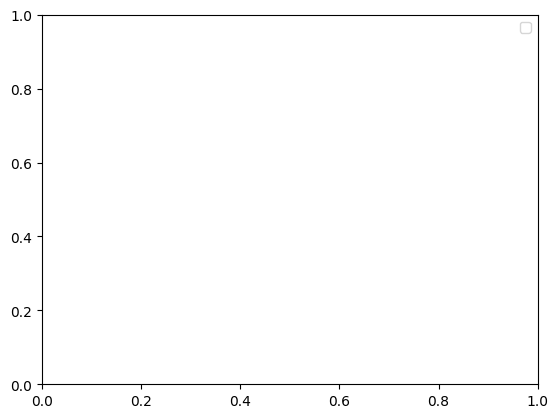

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


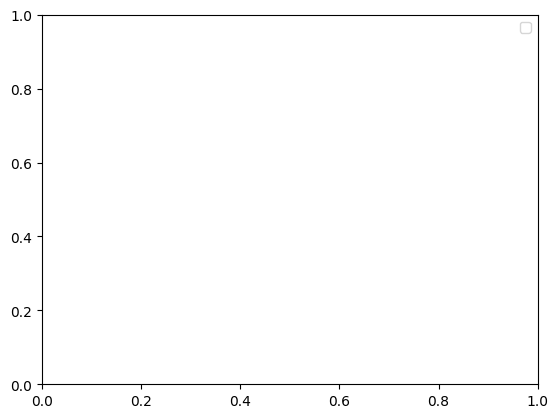

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


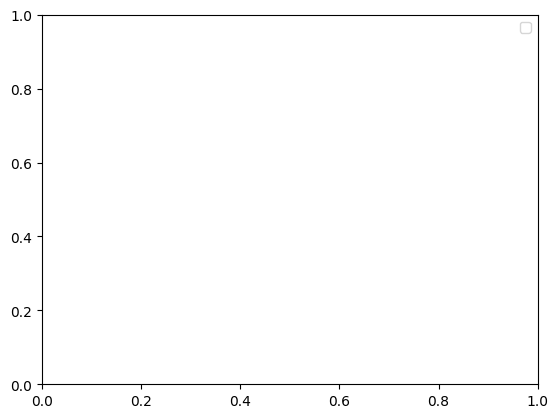

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


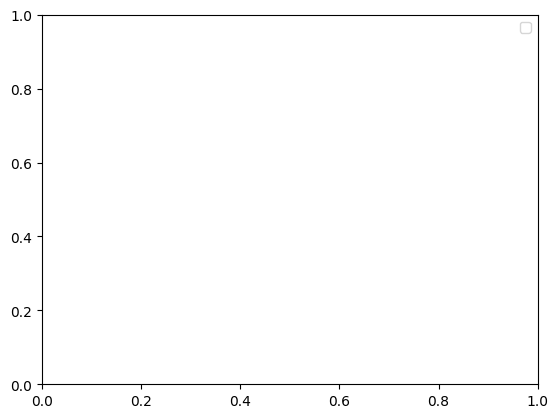

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


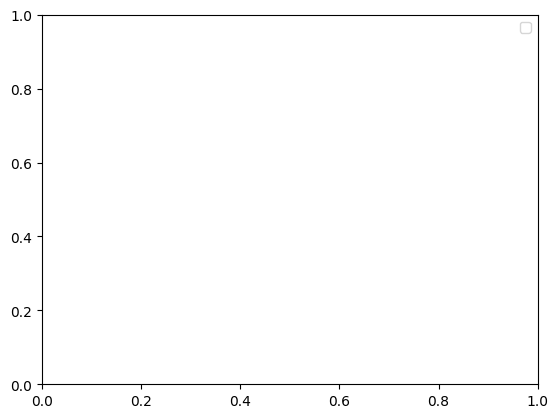

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


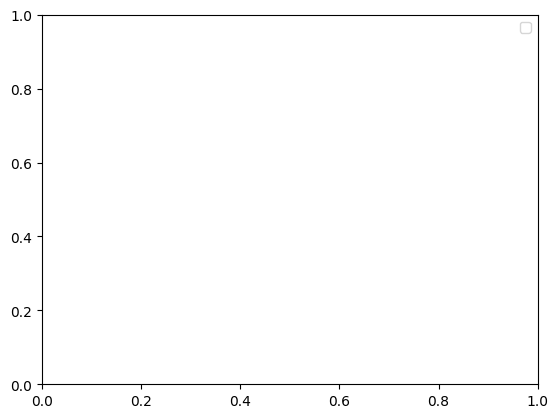

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


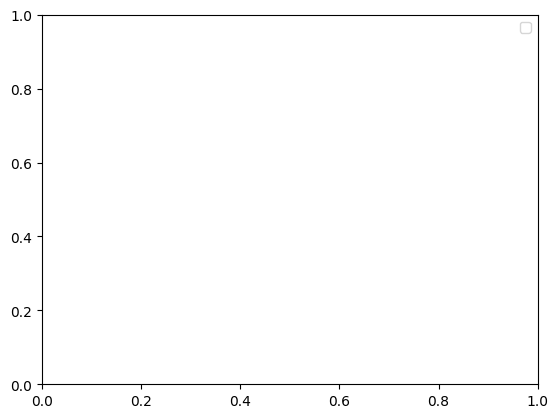

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


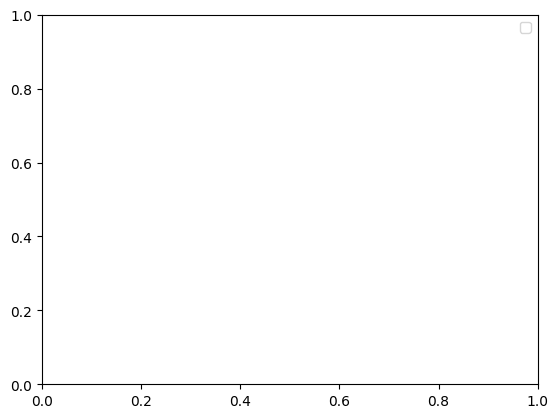

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


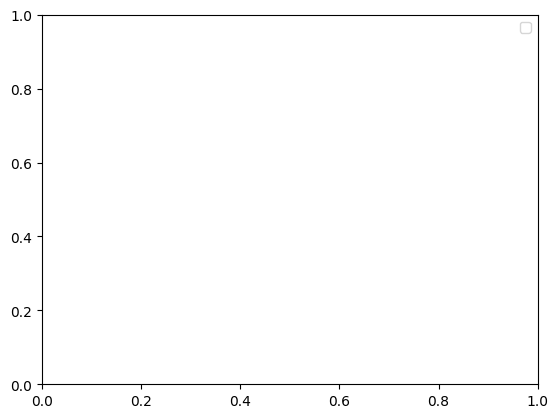

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


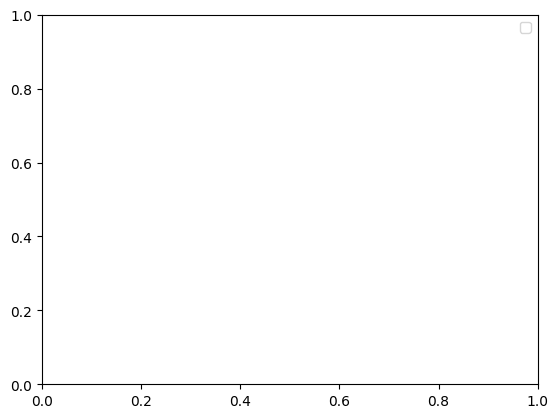

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


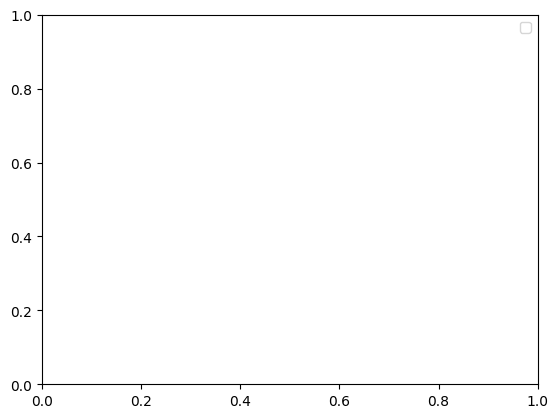

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


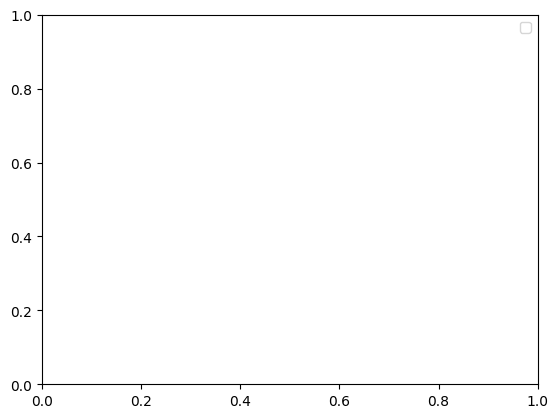

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


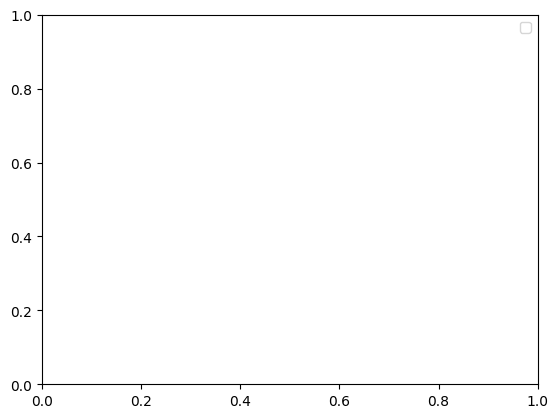

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


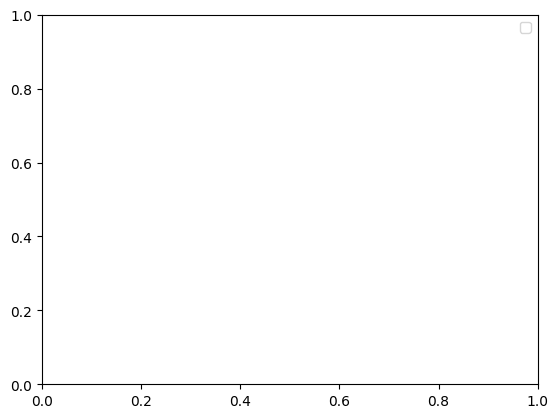

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


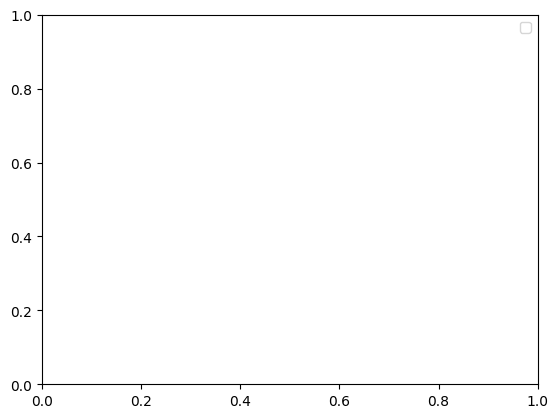

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


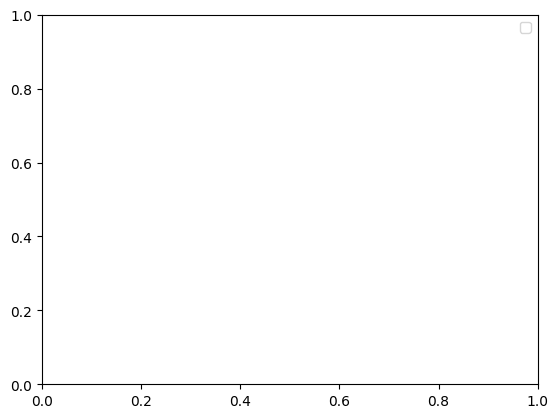

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


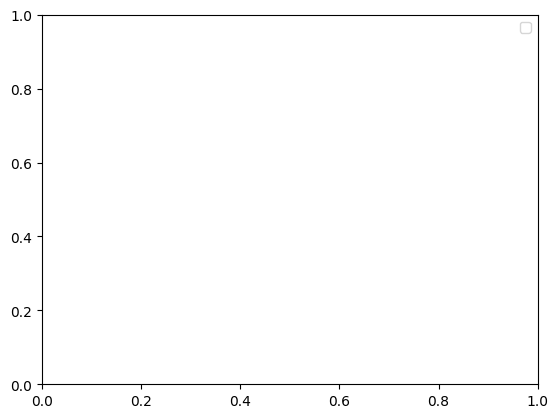

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from utils.dataset_utils import get_subset


def main(seed=None):
    random.seed(seed)

    NGEN = 100  # 迭代次数
    POPSIZE = 40  # 种群数量
    CXPB = 1.0  # 交叉因子/交叉率
    MR = 0.2  # 突变因子/突变率
    # MLP
    learning_rate = 0.001
    max_iter = 200
    hidden_size = 15
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 配置五折交叉验证
    
    # 绘图参数
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.ion()  # 开启交互模式
    ####################################迭代过程的记录#############################
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "fronts", "fronts_0_size", "Acc1", "Acc2", "Acc3"
    ####################################种群的初始化###########################
    pop = toolbox.population(n=POPSIZE)
    ####################################计算初始种群的适应度###########################
    stop_sign = 0
    ensembles = []  # 当前每个个体对应的mlp模型
    # 对于每个个体都训练得到一个mlp模型
    for i in range(len(pop)):
        mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=random_seed,
                            learning_rate_init=learning_rate)
        x_sub, y_sub = get_subset(pop[i], x_train, y_train)
        # 使用 cross_val_predict 进行交叉验证并获取预测
        y_pred = cross_val_predict(mlp, x_sub, y_sub, cv=cv)
        # 用实例选择的子集训练模型
        mlp.fit(x_sub, y_sub)
        pop[i].mlp = mlp
        pop[i].y_sub_and_pred = (y_sub, y_pred)
    # 由mlp模型得到个体的适应度
    for i in range(len(pop)):
        pop[i].fitness.values = toolbox.evaluate(pop[i])
    #################################计算PFC并进行非支配排序#########################################
    # 计算PFC并进行非支配排序 PFC代替拥挤距离
    pop, pareto_fronts = toolbox.select(pop, len(pop))
    ####################################种群的迭代#################################################
    for gen in range(1, NGEN + 1):
        # 选择
        offspring = selTournamentDCD(pop, POPSIZE)
        offspring = [toolbox.clone(ind) for ind in offspring]
        # 交叉
        for i in range(0, len(offspring) - 1, 2):
            if random.random() <= CXPB:
                offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])
            # 突变
            offspring[i] = toolbox.mutate(offspring[i], MR)[0]
            offspring[i + 1] = toolbox.mutate(offspring[i + 1], MR)[0]
            del offspring[i].fitness.values, offspring[i + 1].fitness.values
        # 计算新的种群适应度 
        ensembles.clear()
        for i in range(len(offspring)):
            mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=random_seed,
                                learning_rate_init=learning_rate)
            x_sub, y_sub = get_subset(offspring[i], x_train, y_train)
            # 使用 cross_val_predict 进行交叉验证并获取预测
            y_pred = cross_val_predict(mlp, x_sub, y_sub, cv=cv)
            # 用实例选择的子集训练模型
            mlp.fit(x_sub, y_sub)
            offspring[i].mlp = mlp
            offspring[i].y_sub_and_pred = (y_sub, y_pred)
        for i in range(len(offspring)):
            offspring[i].fitness.values = toolbox.evaluate(offspring[i])
        # 种群的合并
        pop = pop + offspring
        ###############################################得到pareto_fronts############################################
        pop, pareto_fronts = toolbox.select(pop, POPSIZE)
        # print("下一代种群的规模：", len(pop))
        record = stats.compile(pop)
        # 保存第一个等级里的mlp模型进行集成
        for ind in pareto_fronts[0]:
            ensembles.append(ind.mlp)
        ind_rank_0 = pareto_fronts[0][0]
        logbook.record(gen=gen, evals=len(pop), fronts_0_size=len(pareto_fronts[0]),
                       Acc1=ind_rank_0.fitness.values[0], Acc2=ind_rank_0.fitness.values[1],
                       Acc3=ind_rank_0.fitness.values[2], **record)
        # print(logbook.stream)
        # 清除并绘制当前一代的 Pareto-front
        ax.clear()
        plot_pareto(pareto_fronts, ax)
        ax.set_title(f"Generation {gen}")
        ax.set_xlabel("Objective 1")
        ax.set_ylabel("Objective 2")
        ax.set_zlabel("Objective 3")
        plt.legend()
        plt.pause(0.1)
        
    plt.ioff()  # 关闭交互模式
    plt.show()
    return pop, logbook, ensembles


if __name__ == "__main__":
    pop, stats, ensembles = main()
    print("##############################集成分类器的预测结果：################################")
    g_mean, m_auc, recall_per_class = vote_ensembles(ensembles)
    print(f"最终的集成分类结果：Recall_Per_Class{recall_per_class}，Gmean：{g_mean}，mAUC：{m_auc}")